In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement_t = Base.classes.measurement
Station_t = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
#layout of database
measurement_df = pd.read_sql(session.query(Measurement_t).limit(5).statement, engine)

station_df = pd.read_sql(session.query(Station_t).limit(5).statement, engine)

In [12]:
measurement_df

,id,station,date,prcp,tobs
0,0,USC00519397,2010-01-01,2.0,18.3
1,1,USC00519397,2010-01-02,0.0,17.2
2,2,USC00519397,2010-01-03,0.0,23.3
3,3,USC00519397,2010-01-04,0.0,24.4
4,4,USC00519397,2010-01-06,NaN,22.8


In [13]:
station_df

,id,station,name,latitude,longitude,elevation
0,0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,0.914
1,1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,4.450
2,2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,2.133
3,3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,3.627
4,4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,93.447


# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement_t.date)).scalar()
print(most_recent_date)

2017-08-23


In [15]:
# Starting from the most recent data point in the database. 
#start_date = session.query(Measurement_t.date, Measurement_t.prcp).order_by(Measurement_t.date.desc()).first()[0]
start_date = dt.datetime(2017, 8, 23)
# Calculate the date one year from the last date in data set.

end_date = dt.datetime(2016, 8, 23)
# Perform a query to retrieve the data and precipitation scores
year_precipitation = session.query(Measurement_t.date, Measurement_t.prcp).\
    filter(Measurement_t.date > end_date)

# Save the query results as a Pandas DataFrame and set the index to the date column

year_precipitation = pd.read_sql((year_precipitation).statement, engine)
year_precipitation = year_precipitation.set_index('date')

# Sort the dataframe by date
year_precipitation = year_precipitation.sort_values(by='date')
year_precipitation = year_precipitation.groupby('date').max()

year_precipitation.head()

,prcp
date,
2016-08-24,57.9
2016-08-25,5.3
2016-08-26,1.0
2016-08-27,4.6
2016-08-28,52.6


Text(0, 0.5, 'mm')

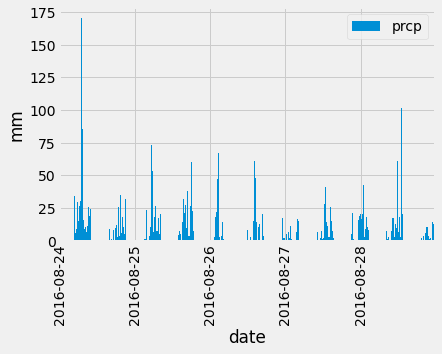

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
y_axis = year_precipitation['prcp']

year_precipitation.plot(kind='bar', use_index=True, y='prcp')

plt.locator_params(axis='x', nbins=5)
plt.xlabel('date')
plt.ylabel('mm')


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_precipitation.describe()

,prcp
count,365.000000
mean,13.143288
std,21.062054
min,0.000000
25%,1.000000
50%,6.400000
75%,16.500000
max,170.200000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
stations_count = session.query(Station_t).distinct(Station_t.station).count()
print(stations_count)

9


c:\Users\Conor\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SADeprecationWarning: DISTINCT ON is currently supported only by the PostgreSQL dialect.  Use of DISTINCT ON for other backends is currently silently ignored, however this usage is deprecated, and will raise CompileError in a future release for all backends that do not support this syntax.
  


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(Measurement_t.station, func.count(Measurement_t.station)).\
    group_by(Measurement_t.station).\
        order_by(func.count(Measurement_t.station).desc()).all()

for station, count in most_active:
    print(f"{station}: {count}")

USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active[0][0]

sel = [func.min(Measurement_t.tobs), func.max(Measurement_t.tobs), func.avg(Measurement_t.tobs)]

most_active_station_temp = session.query(*sel).\
    filter(Measurement_t.station == most_active_station).all()[0]

print(f"Temp Min: {most_active_station_temp[0]}")
print(f"Temp Max: {most_active_station_temp[1]}")
print(f"Temp Avg: {most_active_station_temp[2]}")


Temp Min: 12.2
Temp Max: 29.4
Temp Avg: 22.03582251082252


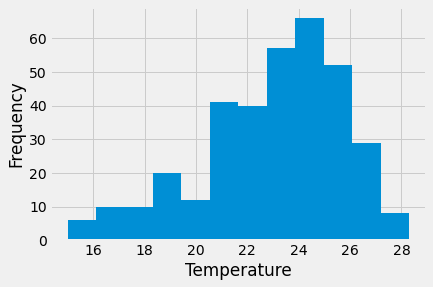

In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# replace INSERT_STATION_ID_HERE with the ID of the most active station
station_tobs = session.query(Measurement_t.tobs).\
    filter(Measurement_t.date >= end_date).\
    filter(Measurement_t.date <= start_date).\
    filter(Measurement_t.station == most_active_station).all()

temp_array = np.ravel(station_tobs)
temp_series = pd.Series(temp_array)

# execute the query and load the data into a pandas DataFrame
temp_series.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [23]:
# Close Session
Session.close()

TypeError: close() missing 1 required positional argument: 'self'